In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
import os

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
shap.initjs()

### Read Data

In [3]:
file = open('../data/splits_data.pkl', 'rb')
splits_data = pickle.load(file)
file.close()

### SHAP values

In [4]:
model = splits_data['2019']['model']
train_features = splits_data['2019']['train_features']
test_features = splits_data['2019']['test_features']
feature_names = splits_data['2019']['feature_names']

X_train = pd.DataFrame(train_features, columns=feature_names)
X_test = pd.DataFrame(test_features, columns=feature_names)

In [5]:
if not os.path.exists('../data/shap_values.pkl'):
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer(X_test, check_additivity=False)

    file = open('../data/shap_values.pkl', 'wb')
    pickle.dump(shap_values, file)
    file.close()
else:
    file = open('../data/shap_values.pkl', 'rb')
    shap_values = pickle.load(file)
    file.close()

### Feature Importance

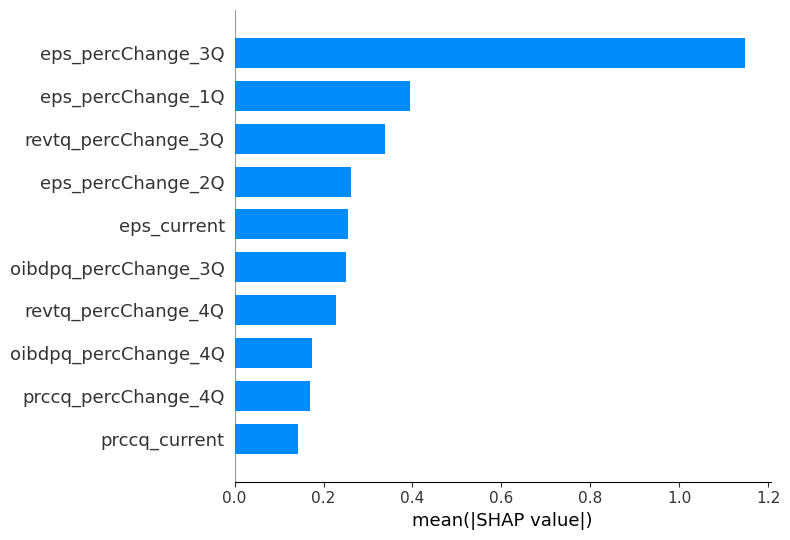

In [6]:
shap.summary_plot(shap_values,max_display=10, plot_type='bar', show=False)
plt.xlabel('mean(|SHAP value|)')
plt.savefig(f'../figures/feature_importance.png', dpi=300, bbox_inches='tight',format='png')

### Group Importance by Financial Items

In [7]:
features_grouped_by_name1 = [x.split('_')[0] for x in feature_names]
features_unique = list(set(features_grouped_by_name1))
features_grouped_by_name2 = {key: [index for index, element in enumerate(features_grouped_by_name1) if element == key] for key in features_unique}

In [8]:
shap_values_grouped_name1 = shap_values.values.copy()

In [9]:
shap_values_grouped_name2 = {key:abs(shap_values_grouped_name1[:, value]).sum(axis=1) for key,value in features_grouped_by_name2.items()}

In [10]:
features_grouped_by_name3 = list(shap_values_grouped_name2.keys())

In [11]:
arrays_list = [v for v in shap_values_grouped_name2.values()]
shap_values_grouped_name3 = np.column_stack(arrays_list)

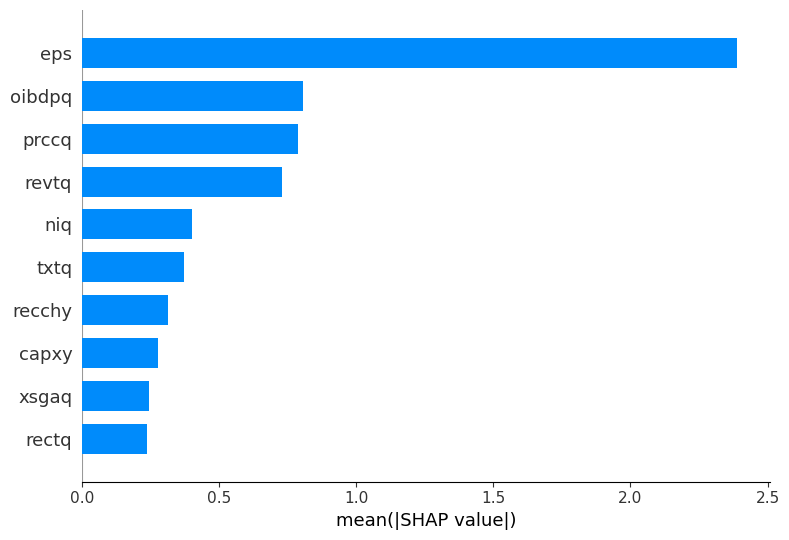

In [12]:
shap.summary_plot(shap_values_grouped_name3,max_display=10, feature_names=features_grouped_by_name3, plot_type='bar', show=False)
plt.xlabel('mean(|SHAP value|)')
plt.savefig(f'../figures/grouped_importance_by_financial.png', dpi=300, bbox_inches='tight',format='png')

### Group Importance by Transformations

In [13]:
features_grouped_by_quarter1 = [''.join(x.split('_')[1:]) for x in feature_names]
features_unique = list(set(features_grouped_by_quarter1))
features_grouped_by_quarter2 = {key: [index for index, element in enumerate(features_grouped_by_quarter1) if element == key] for key in features_unique}

In [14]:
shap_values_grouped_quarter1 = shap_values.values.copy()

In [15]:
shap_values_grouped_quarter2 = {key:abs(shap_values_grouped_quarter1[:, value]).sum(axis=1) for key,value in features_grouped_by_quarter2.items()}

In [16]:
features_grouped_by_quarter3 = list(shap_values_grouped_quarter2.keys())
features_grouped_by_quarter3 = ["".join(["_" + char if char.isdigit() else char for char in string]) for string in features_grouped_by_quarter3]

In [17]:
arrays_list = [v for v in shap_values_grouped_quarter2.values()]
shap_values_grouped_quarter3 = np.column_stack(arrays_list)

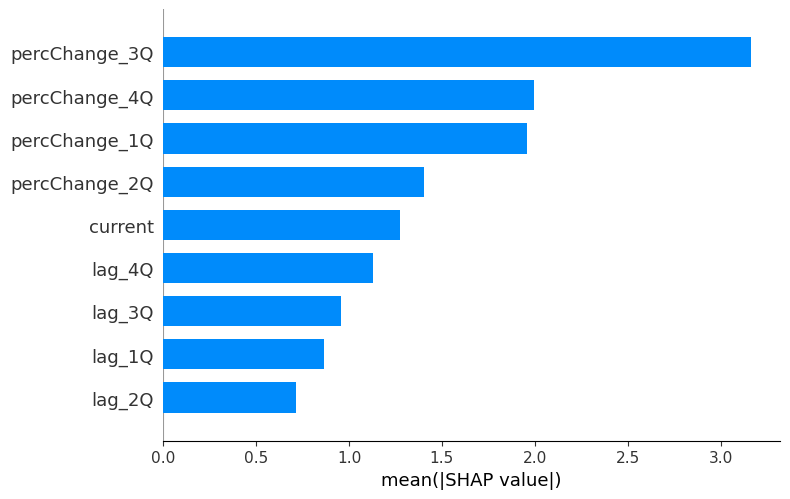

In [18]:
shap.summary_plot(shap_values_grouped_quarter3,max_display=10, feature_names=features_grouped_by_quarter3, plot_type='bar', show=False)
plt.xlabel('mean(|SHAP value|)')
plt.savefig(f'../figures/grouped_importance_by_transformation.png', dpi=300, bbox_inches='tight',format='png')

### SHAP summary plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


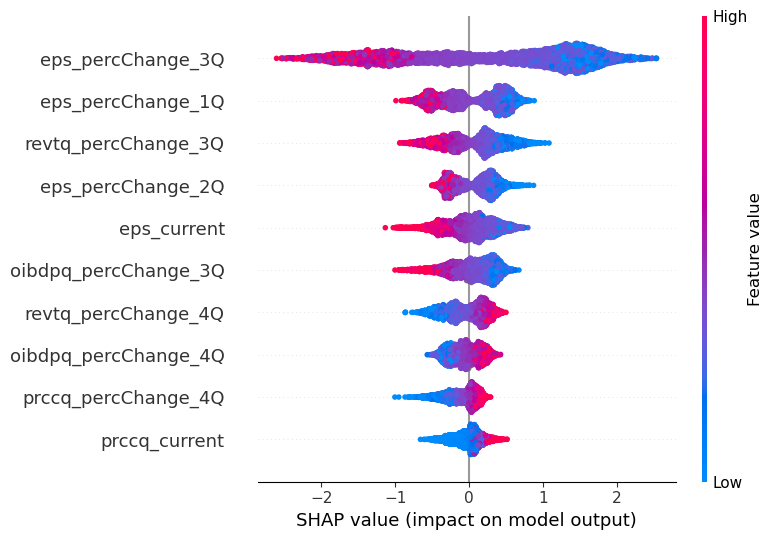

In [19]:
shap.summary_plot(shap_values,max_display=10, show=False)
plt.savefig(f'figures/summary_plot.png', dpi=300, bbox_inches='tight',format='png')

### SHAP dependency plots

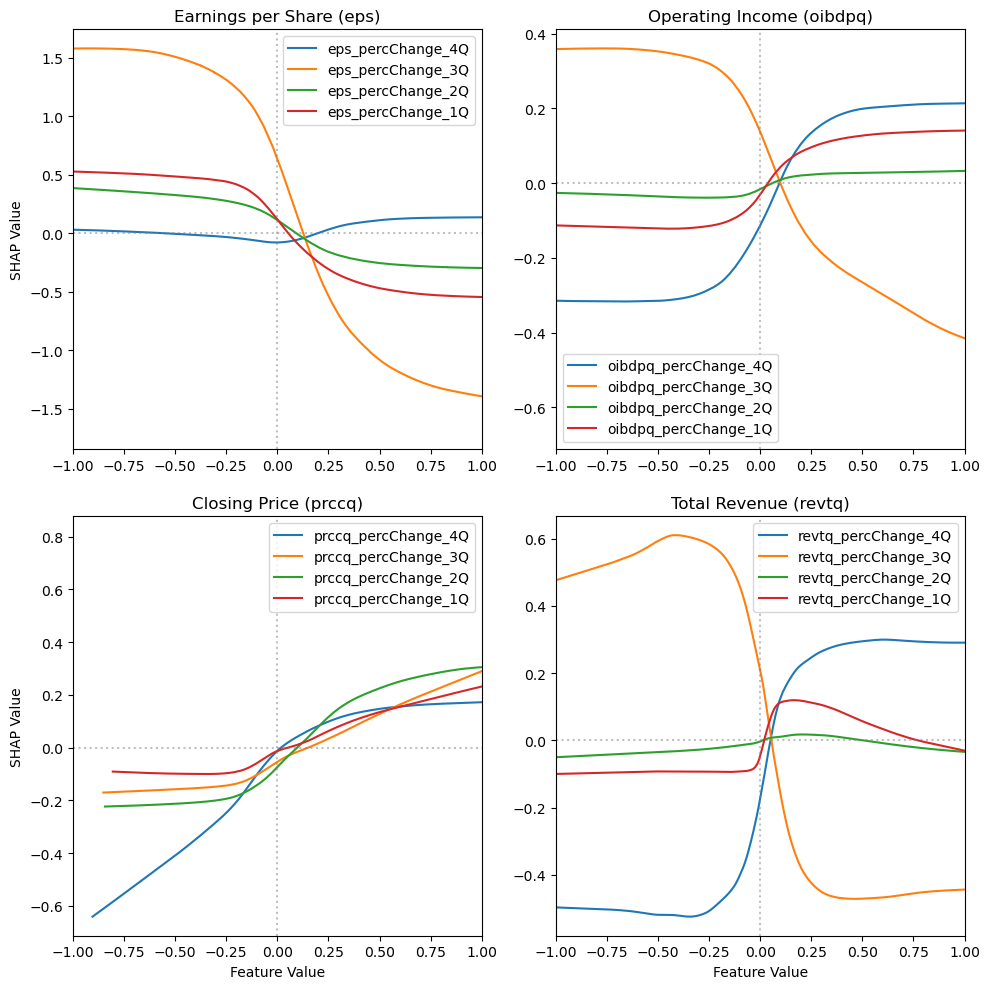

In [20]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define the main features and the quarterly features
main_features = ['eps', 'oibdpq', 'prccq', 'revtq']
main_features2 = ['Earnings per Share', 'Operating Income','Closing Price', 'Total Revenue']
quarterly_feats = ["percChange_4Q", "percChange_3Q", "percChange_2Q", "percChange_1Q"]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Iterate over each main feature and plot on its respective subplot
for i, main_feature in enumerate(main_features):
    feats = [main_feature + '_' + x for x in quarterly_feats]

    for feat in feats:
        x = X_test.iloc[:, feature_names.index(feat)]
        y_sv = shap_values[:, feature_names.index(feat)].values

        lowess = sm.nonparametric.lowess(y_sv, x, frac=0.5)
        axes[i].plot(*zip(*lowess), label=f"{feat}")

    axes[i].axhline(y=0, color='gray', linestyle='dotted', alpha=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='dotted', alpha=0.5)

    axes[i].set_xlim(-1, 1)
    axes[i].set_title(f"{main_features2[i]} ({main_feature})")
    axes[i].legend()

# Set a common ylabel for the left column
axes[0].set_ylabel("SHAP Value")
axes[2].set_ylabel("SHAP Value")
axes[2].set_xlabel("Feature Value")
axes[3].set_xlabel("Feature Value")

plt.tight_layout()
plt.subplots_adjust(hspace=0.16)
plt.savefig(f'figures/shap_values_relationship.png', dpi=300, bbox_inches='tight',format='png')
plt.show()

In [21]:
shap_values[:,feature_names.index("eps_percChange_3Q")].values

array([-0.34498489,  1.82191544,  1.3538845 , ..., -1.61827815,
       -0.53749269,  0.13192749])

In [22]:
eps_shap_values = shap_values[:,feature_names.index("eps_percChange_3Q")].values
eps_data = shap_values[:,feature_names.index("eps_percChange_3Q")].data

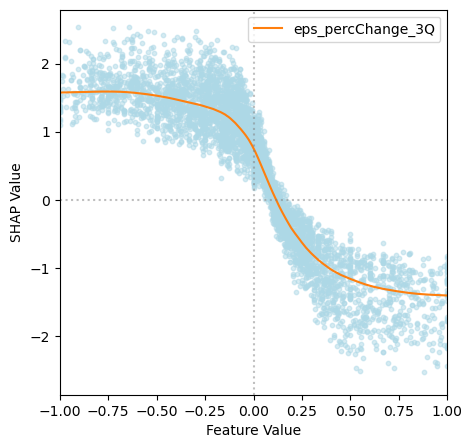

In [23]:
plt.figure(figsize=(5, 5))
feats = ["percChange_3Q"]
feats = ['eps_'+x for x in feats] 
for feat in feats:
    x = X_test.iloc[:, feature_names.index(feat)]
    y_sv = shap_values[:, feature_names.index(feat)].values

    lowess = sm.nonparametric.lowess(y_sv, x, frac=0.3)
    plt.scatter(eps_data,eps_shap_values,color='lightblue', alpha=0.5,s=10)
    plt.plot(*zip(*lowess), label=f"{feat}", color='tab:orange')

plt.axhline(y=0, color='gray', linestyle='dotted', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='dotted', alpha=0.5)

plt.legend()

plt.xlim(-1, 1)
plt.xlabel("Feature Value")
plt.ylabel("SHAP Value")
plt.legend()
plt.savefig(f'figures/shap_value_single.png', dpi=300, bbox_inches='tight',format='png')
plt.show()